<a href="https://colab.research.google.com/github/pjohnst5/StyleTransfer/blob/master/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm.
To understand the importance of a complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

## Results
* Extracted statistics from the content and style images
* Created custom los function in a loss class
* Formulated an optimization problem over an input image
* Optimized the image to match both style and content

An example image:

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
import copy
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [0]:
load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))

Upload Content Image


Saving content1.jpg to content1 (10).jpg

Upload Style Image


Saving style1.jpg to style1 (8).jpg
Content Path: <_io.BytesIO object at 0x7f1bd5287780>
Style Path: <_io.BytesIO object at 0x7f1bd5265620>


In [0]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()

___

### Extract statistics
Created a class to extract the layers needed for statistics

* Used the pretrained VGG in the model
* Gathered statistics from the outputs of intermediate layers for the content image
* Gathered statistics for the style image


In [0]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [0]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]
def get_index(name):
  return vgg_names.index(name)

def get_name(index):
  return vgg_names[index]

# Choose the layers to use for style and content transfer
style_layers = [get_index("conv1_1"), get_index("conv2_1"), get_index("conv3_1"), get_index("conv4_1")]
content_layers = [get_index("conv4_1")]

# Create the vgg network in eval mode
#  with our forward method that returns the outputs of the intermediate layers we requested
style_vgg = VGGIntermediate(style_layers).eval()
content_vgg = VGGIntermediate(content_layers).eval()
img_vgg = VGGIntermediate(style_layers + content_layers).eval()

style_vgg.cuda()
content_vgg.cuda()
img_vgg.cuda()

# Cache the outputs of the content and style layers for their respective images
style_cache = style_vgg(style_image)
content_cache = content_vgg(content_image)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


___

### Transform
Created a method to turn a tensor to an image to display

* The style tensor and content tensor transformed back to an image


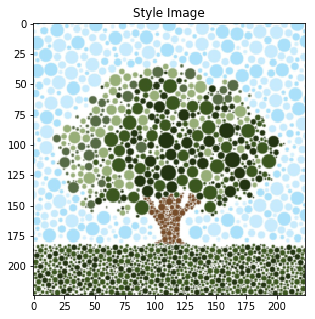

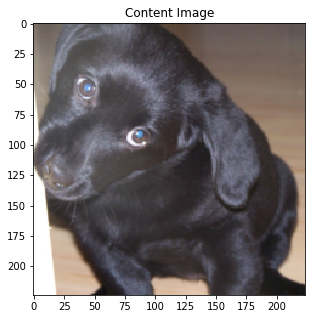

In [0]:
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')

___

### Content and Style loss
Created classes for the style and content loss

* Created a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the class
* Created a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the class

In [0]:
def gram_matrix(input):
  b, f, h, w = input.size()
  features = input.view(b * f, h * w)
  basis = torch.mm(features, features.t())
  return basis.div(b * f * h * w)
  
  
class ContentLoss(nn.Module):
  def __init__(self, layer_cache):
    super(ContentLoss, self).__init__()
    self.target = layer_cache.detach()
    
  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return self.loss
    
class StyleLoss(nn.Module):
  def __init__(self, layer_cache):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(layer_cache).detach()
  
  def forward(self, input):
    self.loss = F.mse_loss(gram_matrix(input), self.target)
    return self.loss

# Instantiate a content loss module for each content layer 
#  with the content reference image outputs for that layer for comparison
content_losses = {}
for key, value in content_cache.items():
  content_losses[key] = ContentLoss(value)

# Instantiate a sytle loss module for each style layer 
#  with the style reference image outputs for that layer for comparison
style_losses = {}
for key, value in style_cache.items():
  style_losses[key] = StyleLoss(value)

___

### Minimizing loss
Created and ran a method that minimizes the content and style loss for a copy of the content image
* Used an Adam optimizer with learning rate of .1
* Showed both the content and the style loss every 50 steps
* Ensured that the outputs don't go out of range (clamp them)
* Displayed the tensor as an image!


epoch:299, content_loss:191.4536, style_loss:0.005: 100%|██████████| 300/300 [00:18<00:00, 16.22it/s]

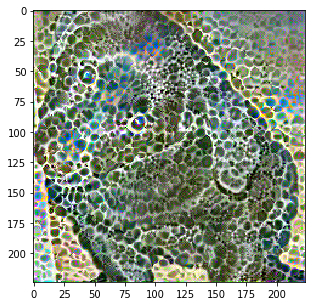

In [0]:
# Start with a copy of the content image
content_image_copy = copy.deepcopy(content_image)

# Run the optimizer on the images to change the image
#  using the loss of the style and content layers
#  to backpropagate errors 
  
num_epochs = 300
optimizer = optim.Adam([content_image_copy.requires_grad_(True)], lr=0.1)
alpha = 1
beta = 10000
content_loss_values = []
style_loss_values = []

loop = tqdm(total=num_epochs, position=0, leave=False)

for epoch in range(num_epochs):
  content_image_copy.data.clamp_(0,1)
  optimizer.zero_grad()
  img_cache = img_vgg(content_image_copy)
  
  content_loss = None
  for key, content_module in content_losses.items():
    if content_loss is None:
      content_loss = content_module(img_cache[key])
    else:
      content_loss += content_module(img_cache[key])
  
  style_loss = None
  for key, style_module in style_losses.items():
    if style_loss is None:
      style_loss = style_module(img_cache[key])
    else:
      style_loss += style_module(img_cache[key])
      
  style_loss *= 1/(len(style_layers))
  
  if epoch % 50 == 0:
    content_loss_values.append(content_loss.item())
    style_loss_values.append(style_loss.item())
  
  loss = (alpha * content_loss) + (beta * style_loss)
  loss.backward()
  
  optimizer.step()
  
  loop.set_description('epoch:{}, content_loss:{:.4f}, style_loss:{:.3f}'.format(epoch, content_loss.item(), style_loss.item()))
  loop.update(1)

# Show the image
plt.rcParams['figure.figsize'] = [15,5]
content_image_copy.data.clamp_(0,1)
display(content_image_copy)

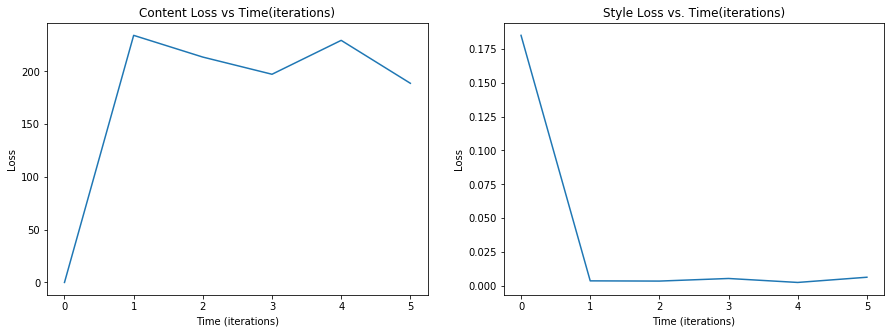

In [0]:
plt.subplot(121)
plt.title("Content Loss vs Time(iterations)")
plt.xlabel("Time (iterations)")
plt.ylabel("Loss")
plt.plot(content_loss_values)

plt.subplot(122)
plt.title("Style Loss vs. Time(iterations)")
plt.xlabel("Time (iterations)")
plt.ylabel("Loss")
plt.plot(style_loss_values)
plt.show()

### Further explantion of equations

- Equation (1) on p. 10 of (Gatys 2016) in plain English.
  - p is the original image, x is the image that is generated, l is the layer. i represents the filter in layer l, j represents the position of this filter. P is the feature representation of the original image, F is the feature representation of the generated image. P subscript ij superscript l is the feature representation of layer l, with filter i at position j. Same as F. The loss is the squared difference between the the feature representation of the original image and the generated image.
  
- Equation (3) on p. 11 of (Gatys 2016) in plain English.
  - G_i_j^l is the gram matrix of layer l of feature map i and j. Each layer has k channels (the result of multiple filter multiplication). F_i_k and F_j_k are transposed matrices of each other for layer l. We multiply those together and do this for each channel of layer l in order to get the gram matrix for feature map i and j at layer l.
- Equation (4) on p. 11 of (Gatys 2016) in plain English.
  - A^l is the style representation of the original image at layer l, G^l is the style representation of the generated image at layer l. G_i_j^l then is the style representation of the generated image at layer l from filter i at position j. We then square the difference between the original and generated images and sum that difference for each filter and position. The division outfront of 1/(4N^2M^2) scales the loss by the magnitude of the number of filters and size of those filters.
- Equation (5) on p. 11 of (Gatys 2016) in plain English.
  - This equation gives the total style loss by summing the loss from each layer (El) and multiplying each of those losses by a weight (wl).